### Practica 4: 
#### Problema 2:

Entrenar y evaluar la performance de un autoencoder variacional convolucional
que aprende a generar d´ıgitos manuscritos a partir de la base
de datos MNIST.

## Definimos dos redes: encoder y decoder

### Encoder:
transforma una imagen real a una media y variancia del espacio latente

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28,28,1))   # imagenes MNIST
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean =  layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3136)      │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │     50,192 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder:
transforma puntos del espacio latente devuelta a imagenes

In [33]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(latent_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Espacio Latente:
capa de sampleo que toma una media y varianza, y las usa para samplear puntos random del espacio latente

In [34]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size,z_size))
        return z_mean+tf.exp(0.5*z_log_var)*epsilon

## Modelo VAE:  

In [ ]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_hist = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_hist = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_hist = keras.metrics.Mean(name='kl_loss')
    
    def call(self, inputs):
        """Define la pasada hacia adelante del modelo (usada en validación y predicción)."""
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampler([z_mean, z_log_var])
        return self.decoder(z)

    @property
    def metrics(self):
        return [self.total_loss_hist,self.reconstruction_loss_hist,self.kl_loss_hist]
    
    def train_step(self,data):
        with tf.GradientTape() as g:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.categorical_crossentropy(data,reconstruction),axis=(1,2)))
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data,reconstruction),axis=(1,2)))
            kl_loss = -0.5*( 1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var) )
            total_loss = reconstruction_loss+tf.reduce_mean(kl_loss)

        grads = g.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_hist.update_state(total_loss)
        self.reconstruction_loss_hist.update_state(reconstruction_loss)
        self.kl_loss_hist.update_state(kl_loss)
        return {'total_loss':self.total_loss_hist.result(),
                'reconstruction_loss':self.reconstruction_loss_hist.result(),
                'kl_loss':self.kl_loss_hist.result()}
    
    def test_step(self, data):
        z_mean, z_log_var = self.encoder(data)
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)))
        kl_loss = -0.5*tf.reduce_mean(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
        total_loss = reconstruction_loss+kl_loss

        self.total_loss_hist.update_state(total_loss)
        self.reconstruction_loss_hist.update_state(reconstruction_loss)
        self.kl_loss_hist.update_state(kl_loss)

        return {
            'total_loss': self.total_loss_hist.result(),
            'reconstruction_loss': self.reconstruction_loss_hist.result(),
            'kl_loss': self.kl_loss_hist.result()
        }


## Entrenamiento de la Red

In [36]:
import numpy as np

# Cargo datos MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [37]:
epochs_num=50
batch_size=128

callback = keras.callbacks.EarlyStopping(monitor='val_total_loss',
                                         mode='min',
                                         patience=3,
                                         restore_best_weights=True)

vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam(),run_eagerly=True)
history = vae.fit(x_train,
        epochs=epochs_num,
        batch_size=batch_size,
        validation_split = 0.15,
        callbacks=[callback])
vae.summary()

Epoch 1/50


C:\Users\anapa\AppData\Local\Temp\ipykernel_9692\1029720772.py:26: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(128, 28, 28, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.categorical_crossentropy(data,reconstruction),axis=(1,2)))


399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - kl_loss: 1394477760512.0000 - reconstruction_loss: 0.0000e+00 - total_loss: 1394463211520.0000

C:\Users\anapa\AppData\Local\Temp\ipykernel_9692\1029720772.py:26: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(56, 28, 28, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.categorical_crossentropy(data,reconstruction),axis=(1,2)))


399/399 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - kl_loss: 1401382633472.0000 - reconstruction_loss: 0.0000e+00 - total_loss: 1401353404416.0000 - val_kl_loss: 6.8890 - val_reconstruction_loss: 2209852.2500 - val_total_loss: 2209859.7500
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 61s 153ms/step - kl_loss: 9.0214 - reconstruction_loss: 0.0000e+00 - total_loss: 9.0214 - val_kl_loss: 16.4171 - val_reconstruction_loss: 3596849.0000 - val_total_loss: 3596865.2500
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 104s 260ms/step - kl_loss: 19.7089 - reconstruction_loss: 0.0000e+00 - total_loss: 19.7090 - val_kl_loss: 31.2866 - val_reconstruction_loss: 5042496.5000 - val_total_loss: 5042527.5000
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 107s 268ms/step - kl_loss: 36.2350 - reconstruction_loss: 0.0000e+00 - total_loss: 36.2351 - val_kl_loss: 52.8673 - val_reconstruction_loss: 6900658.5000 - val_total_loss: 6900710.0000


Model: "vae_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2)) │        69,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        65,089 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampler_5 (Sampler)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,497 (1.54 MB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,332 (1.02 MB)

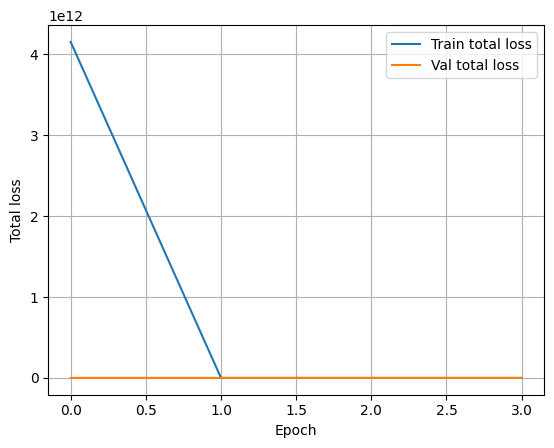

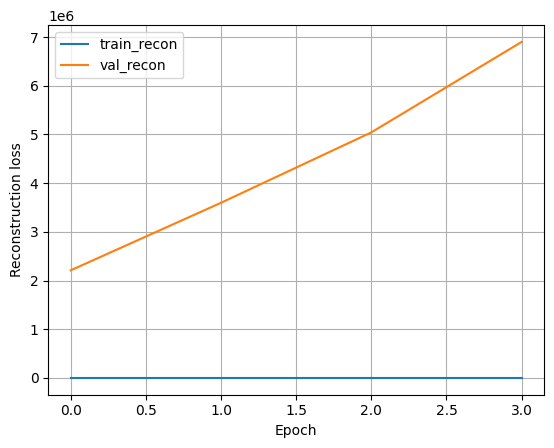

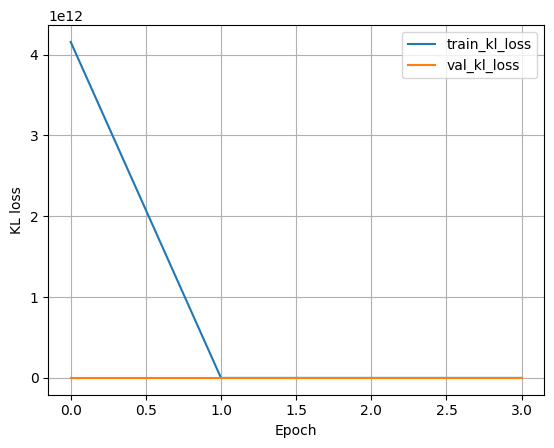

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['total_loss'], label='Train total loss')
plt.plot(history.history['val_total_loss'], label='Val total loss')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['reconstruction_loss'], label='train_recon')
plt.plot(history.history['val_reconstruction_loss'], label='val_recon')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['kl_loss'], label='train_kl_loss')
plt.plot(history.history['val_kl_loss'], label='val_kl_loss')
plt.xlabel('Epoch')
plt.ylabel('KL loss')
plt.legend()
plt.grid()
plt.show()

In [39]:
# Para separar el validation set igual que en fit
val_split = int(0.15 * len(x_train))
x_val = x_train[:val_split]
x_train_real = x_train[val_split:]

# Evaluar en cada conjunto
train_metrics = vae.evaluate(x_train_real, batch_size=batch_size, verbose=0)
val_metrics = vae.evaluate(x_val, batch_size=batch_size, verbose=0)
test_metrics = vae.evaluate(x_test, batch_size=batch_size, verbose=0)

print("Train metrics:", train_metrics)
print("Validation metrics:", val_metrics)
print("Test metrics:", test_metrics)

Train metrics: [2243827.0, 2243821.75, 6.89245080947876]
Validation metrics: [2254502.0, 2254494.75, 6.909328460693359]
Test metrics: [2292514.75, 2292508.5, 6.91786527633667]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


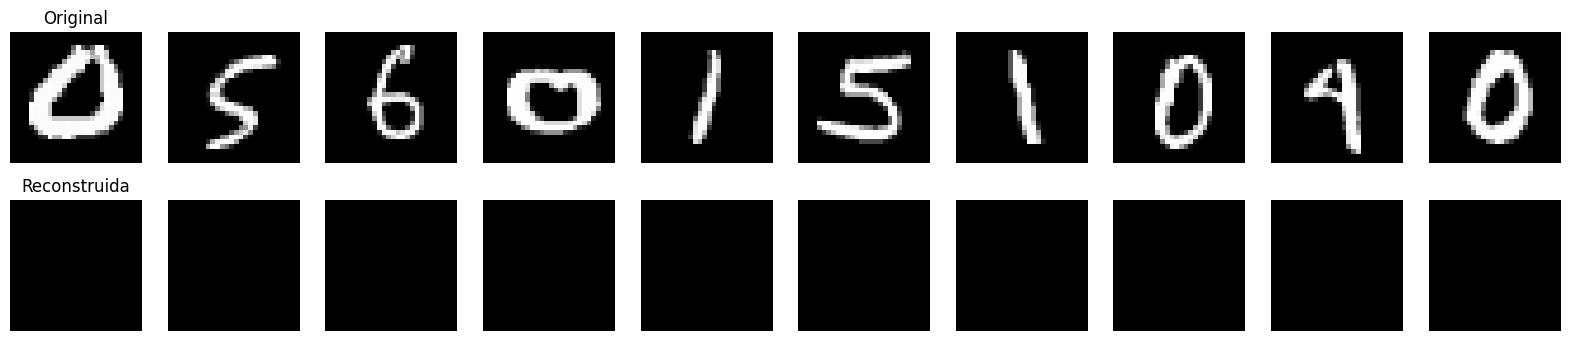

In [40]:
n = 10
indices = np.random.randint(0, len(x_test), n)
samples = x_test[indices]
reconstructions = vae.predict(samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    # Reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstruida')
plt.show()


## Sampleo al espacio latente

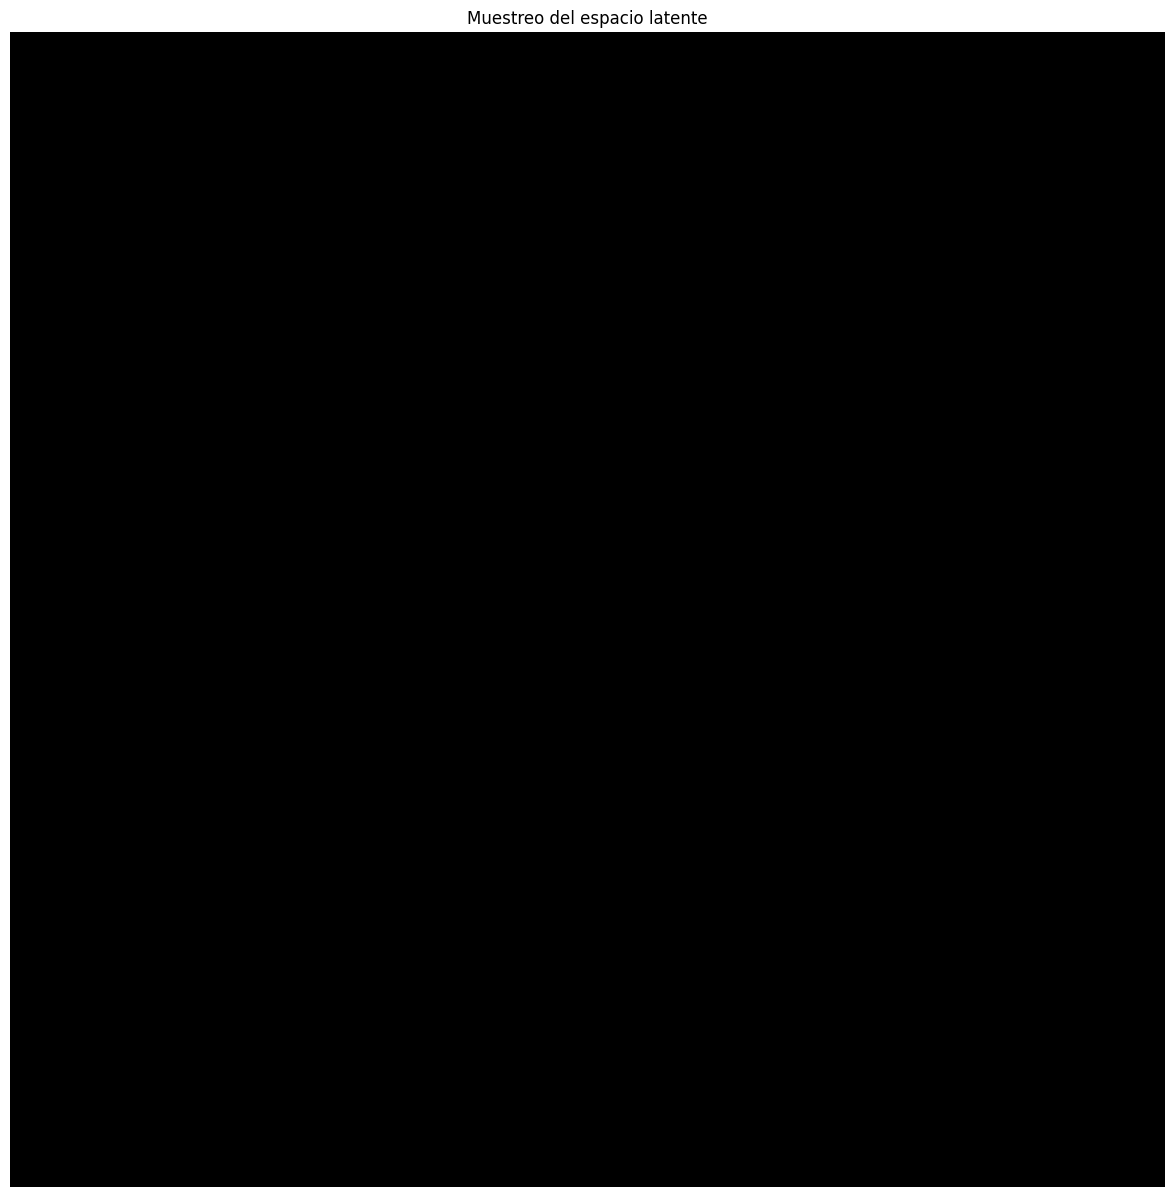

In [41]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))

grid_x = np.linspace(-1,1,n)
grid_y = np.linspace(-1,1,n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xj in enumerate(grid_x):
        z_sample = np.array([[xj,yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size, ] = digit

plt.figure(figsize=(15,15))
start_range = digit_size//2
end_range = n*digit_size+start_range
pixel_range = np.arange(start_range,end_range,digit_size)
sample_range_x = np.round(grid_x,1)
sample_range_y = np.round(grid_y,1)
plt.imshow(figure, cmap='Greys_r')
plt.xticks(pixel_range,sample_range_x)
plt.yticks(pixel_range,sample_range_y)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.title("Muestreo del espacio latente")
plt.axis('off')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


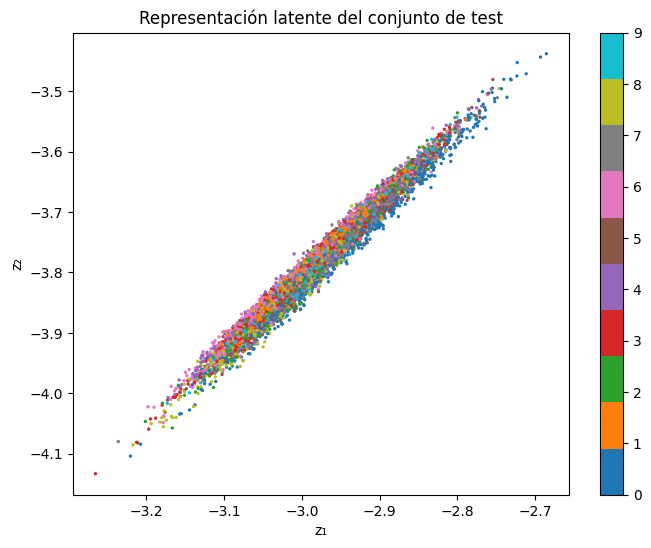

In [42]:
z_mean, z_log_var = vae.encoder.predict(x_test)
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', s=2)
plt.colorbar()
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.title("Representación latente del conjunto de test")
plt.show()


### Modelo VAE arquitectura

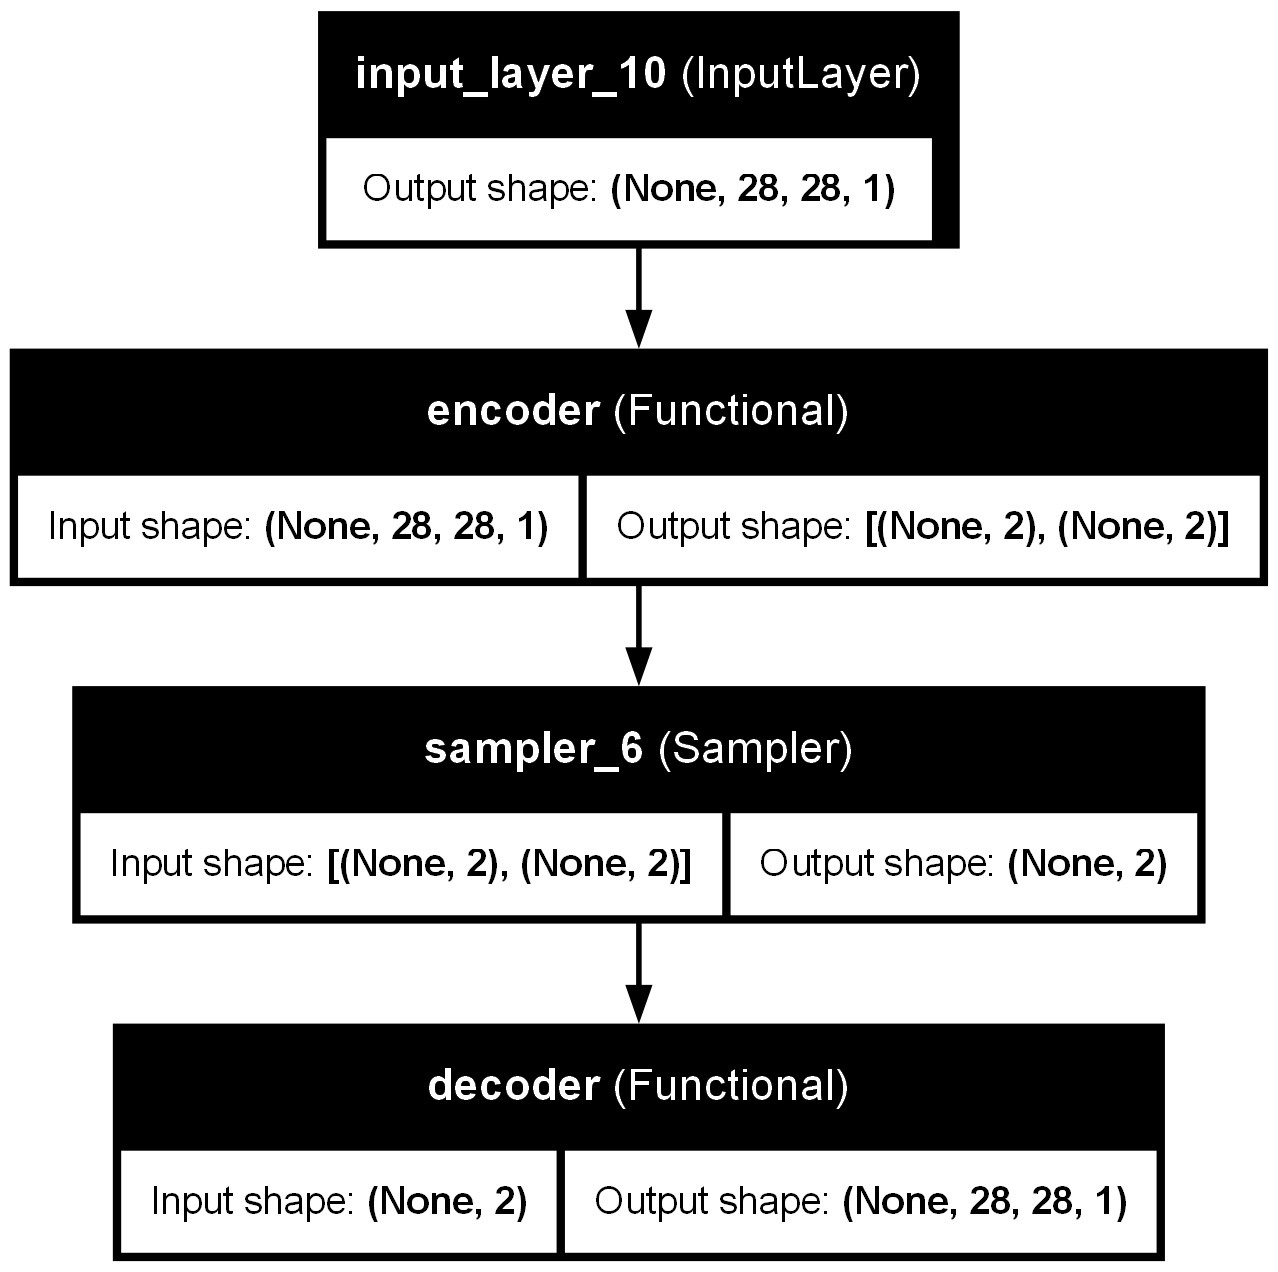

In [43]:
from tensorflow.keras.utils import plot_model

inputs = keras.Input(shape=(28, 28, 1))
z_mean, z_log_var = encoder(inputs)
z = Sampler()([z_mean, z_log_var])
outputs = decoder(z)

vae_visual = keras.Model(inputs, outputs, name="VAE_visual")
plot_model(vae_visual, show_shapes=True, show_layer_names=True, to_file="cross_entropy/vae_visual.png")


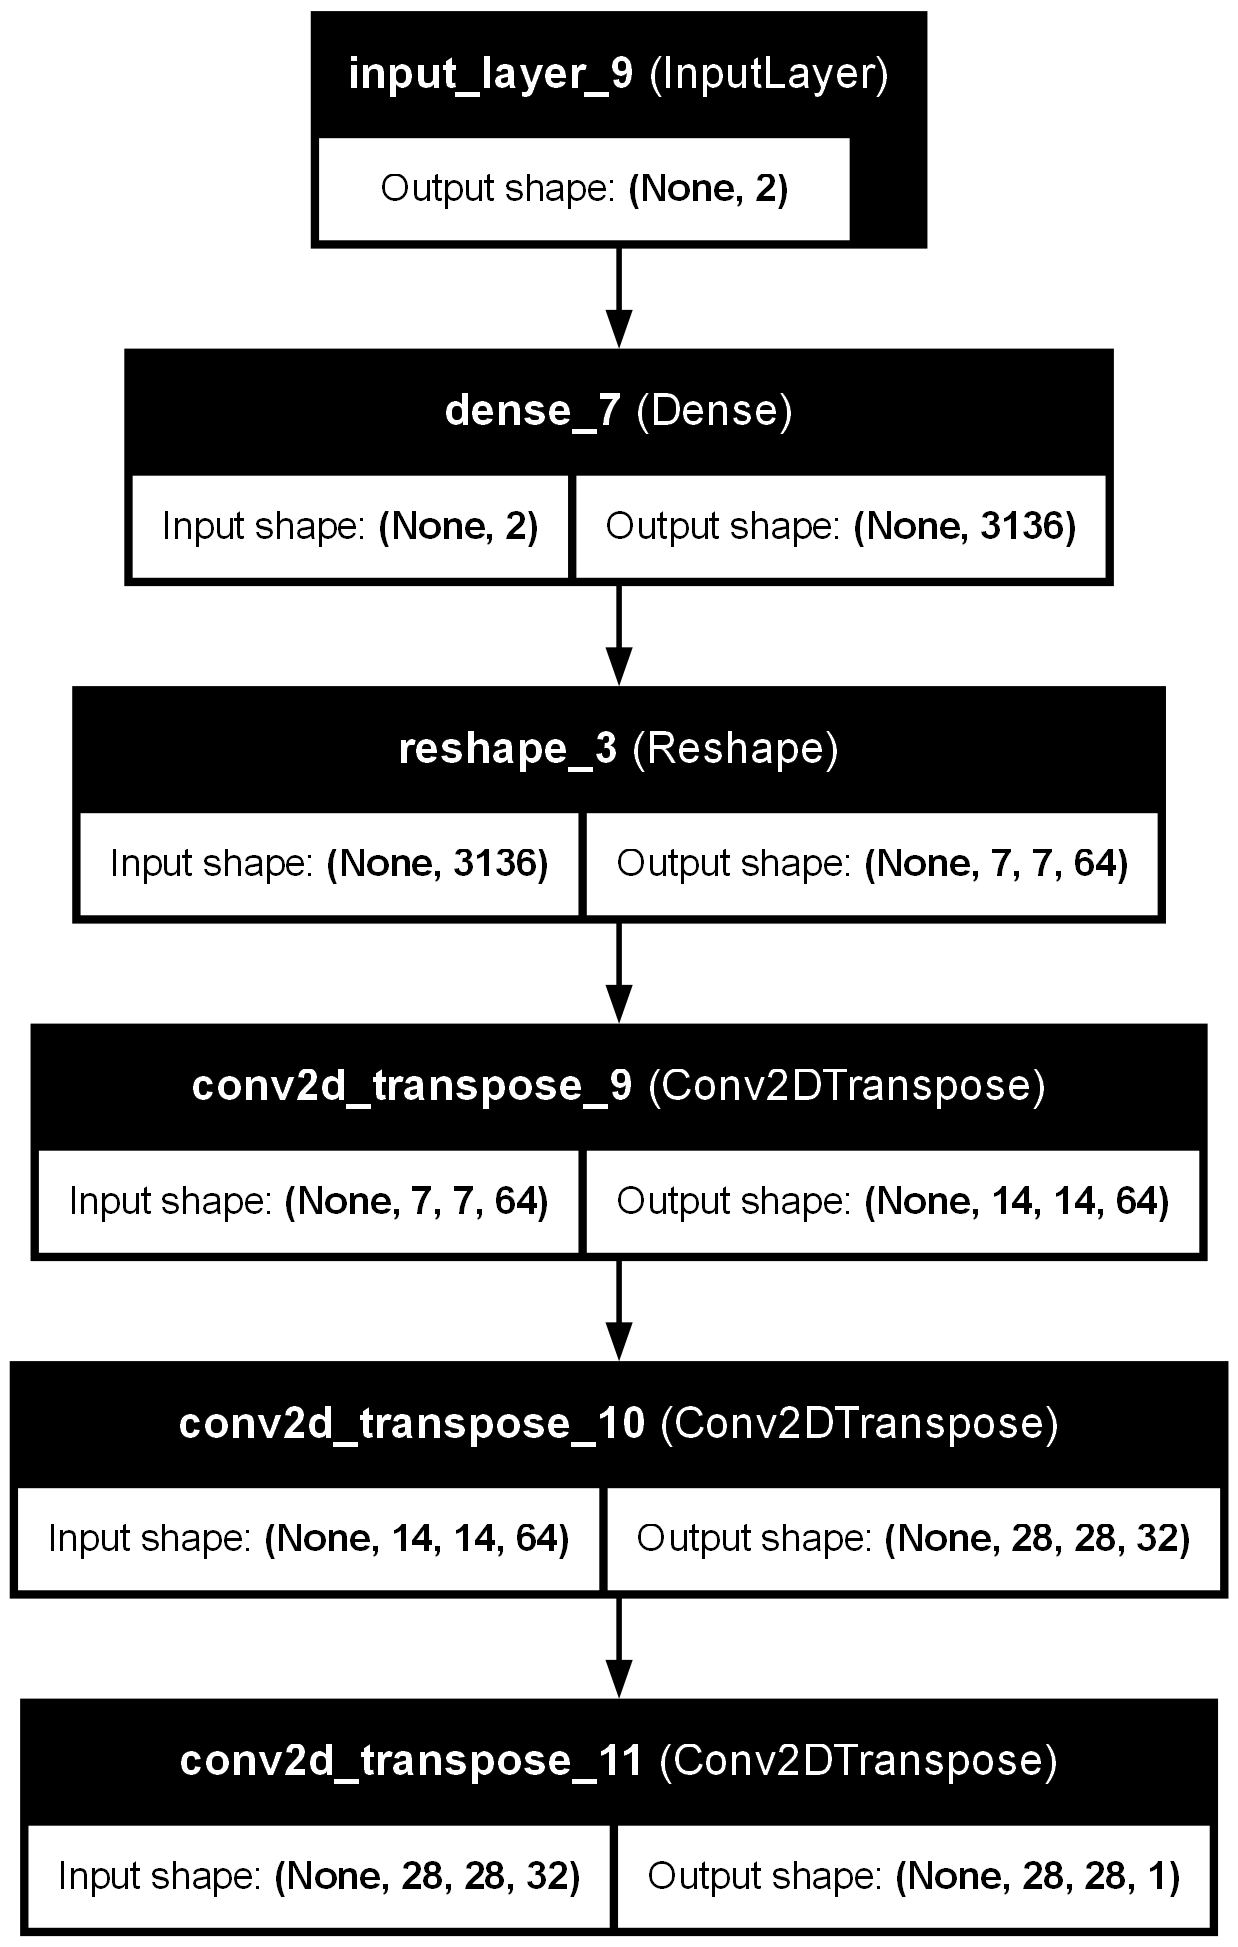

In [44]:
from tensorflow.keras.utils import plot_model

plot_model(encoder, show_shapes=True, show_layer_names=True, to_file="cross_entropy/encoder.png")
plot_model(decoder, show_shapes=True, show_layer_names=True, to_file="cross_entropy/decoder.png")


otro

In [ ]:
# =====================================================
# Variational Autoencoder Convolucional (VAE) - MNIST
# =====================================================

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import imageio

# ======================
# 1. Cargar MNIST
# ======================
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
test_dataset  = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

# ======================
# 2. Definir Encoder
# ======================
latent_dim = 2  # espacio latente 2D para visualización

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(latent_dim * 2),  # media y logvar
])

# ======================
# 3. Reparametrización
# ======================
def reparameterize(mu, logvar):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * logvar) * eps

# ======================
# 4. Definir Decoder
# ======================
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    tf.keras.layers.Dense(7*7*64, activation='relu'),
    tf.keras.layers.Reshape((7,7,64)),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid'),
])

# ======================
# 5. Función de pérdida
# ======================
def compute_loss(model, x, loss_type="crossentropy"):
    mu_logvar = model['encoder'](x)
    mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
    z = reparameterize(mu, logvar)
    x_logit = model['decoder'](z)
    
    if loss_type == "crossentropy":
        reconstruction_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_logit), axis=(1,2)
        )
    else:
        reconstruction_loss = tf.reduce_sum(tf.keras.losses.mse(x, x_logit), axis=(1,2))
    
    kl_div = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    
    total_loss = tf.reduce_mean(reconstruction_loss + kl_div)
    return total_loss

# ======================
# 6. Entrenamiento
# ======================
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step(model, x, loss_type):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, loss_type)
    gradients = tape.gradient(loss, model['encoder'].trainable_variables + model['decoder'].trainable_variables)
    optimizer.apply_gradients(zip(gradients, model['encoder'].trainable_variables + model['decoder'].trainable_variables))
    return loss

model = {'encoder': encoder, 'decoder': decoder}

epochs = 20
for epoch in range(epochs):
    for train_x in train_dataset:
        loss = train_step(model, train_x, loss_type="crossentropy")
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

# ======================
# 7. Muestreo del espacio latente
# ======================
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.axis("off")
plt.show()

# ======================
# 8. Probar pérdida MSE
# ======================
# Para usar MSE en lugar de cross-entropy, simplemente cambia loss_type en train_step:
# loss = train_step(model, train_x, loss_type="mse")
